# What do we know about vaccines and therapeutics? Team 6.3

## References
* COVID-19 Literature Clustering - https://www.kaggle.com/maksimeren/covid-19-literature-clustering
* Topic Modeling: Finding Related Articles - https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles

# Prerequisites to run the notebook

#### 1) Install additional libraries

In [ ]:
!pip install spacy scispacy spacy_langdetect https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.3/en_core_sci_lg-0.2.3.tar.gz --user

In [ ]:
!python -m spacy download 'en_core_web_sm' --user
!python -m spacy link en_core_web_sm en 

In [ ]:
!pip install wordcloud --user
!pip install nltk --user
!pip install gensim --user
!pip install bert-extractive-summarizer --user
!pip install spacy>=2.1.3 --user
!pip install transformers>=2.2.2 --user
!pip install neuralcoref --user
!python -m spacy download en_core_web_md --user

#### 2) Make sure all data are accessible

#### 3) Restart notebook (to make installed packages available)

# Sources
 * COVID-19 Open Research Dataset

# Load packages

In [28]:
import numpy as np 
import pandas as pd

import glob
import json

import scispacy
import spacy
import en_core_sci_lg as en_core_sci_md
from spacy_langdetect import LanguageDetector
import en_core_web_sm

import pickle
import os
import csv
import re
import datetime

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

from scipy.spatial.distance import jensenshannon

import joblib
from IPython.display import HTML, display, Image

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

import string
import nltk
import configparser
from gensim.models import FastText
from tqdm import tqdm
from sklearn.decomposition import LatentDirichletAllocation
tqdm().pandas()

from summarizer import Summarizer
from wordcloud import WordCloud


0it [00:00, ?it/s]
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Introduction
At the end of December, WHO was informed of a cluster of cases of pneumonia of unknown cause detected in Wuhan City, Hubei Province of China. On 11 February 2020, WHO announced a name for the new coronavirus disease: COVID-19. Since then virus spread to 213 countries all over the world,  there are 1 844 863 confirmed cases of covid-19 and 117 021 deaths because of the virus (as of April 14th 2020). 

In response to the COVID-19 pandemic scientists, physicians, funders and manufacturers work 24/7 to find a vaccine against the disease as well as drugs to treat patients.

Every day a large number of papers is published and try to answers to high priority scientific questions.

COVID-19 Open Research Dataset is a set of abstracts and full-text articles on COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to community via kaggle competition to  call to action to the world's artificial intelligence experts to apply NLP and other AI techniques to generate insights in support of the ongoing fight against this infectious disease.

In this notebook we will try to support medical community and within coronavirus literature find an answer to the question what we know about vaccines and theraupetics against covid-19.

In [2]:
Image(url='https://images.jifo.co/22486206_1586441876420.png')
# source: https://www.who.int/emergencies/diseases/novel-coronavirus-2019

# List of content:
1. Data load
2. Data cleaning
3. Data exploration
4. Clustering
5. Keywords generation
6. Tokenize and generate similar keywords
7. Topic modelling
8. Filtering
9. Get similiar documents
10. Summary

# 1) Data load

In [3]:
## PLEASE UPDATE YOUR DATA PATH HERE
root_path = '/hackathon/covid-19/data'

In [4]:
# load metadata
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head(1)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...


In [5]:
# load all json
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json) # should be 88626

88626

In [6]:
# read json files
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            if 'abstract' in content:
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
    
dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}
for entry in tqdm(all_json):
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
papers = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])
papers.head(1)

100%|██████████| 88626/88626 [05:39<00:00, 260.86it/s]


,paper_id,abstract,body_text
0,bd667dbd5200c9f07fb07cef29435f7ca7c2639b,Since there is no available serological method...,"Epizootic catarrhal enteritis (EcE), a new ent..."


In [7]:
# merge with metadata
df = pd.merge(papers, meta_df, left_on='paper_id', right_on='sha', how='left').drop('sha', axis=1)

# 2) Clean data

In [8]:
# use abstracts from the metadata when possible, fill the missing values with the abstract from the extracted values from the JSON file.
df.loc[df.abstract_y.isnull() & (df.abstract_x != ''), 'abstract_y'] = df[(df.abstract_y.isnull()) & (df.abstract_x != '')].abstract_x
df.rename(columns = {'abstract_y': 'abstract'}, inplace=True)
df.drop('abstract_x', axis=1, inplace=True)

In [9]:
# drop duplicates
df.drop_duplicates(['paper_id', 'body_text'], inplace=True)

In [10]:
# language detection of abstracts
nlp = en_core_sci_md.load(disable=["tagger", "ner"])
nlp.max_length = 2000000
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [11]:
# keep only english language of abstracts
df['abstract_lang'] = df.abstract.progress_apply(lambda x: nlp(str(x))._.language['language'])

100%|██████████| 60042/60042 [12:30<00:00, 79.96it/s] 


In [12]:
# language only english language of body text
df['body_lang'] = df.body_text.progress_apply(lambda x: nlp(str(x[:2000]))._.language['language'])

100%|██████████| 60042/60042 [25:48<00:00, 38.77it/s]


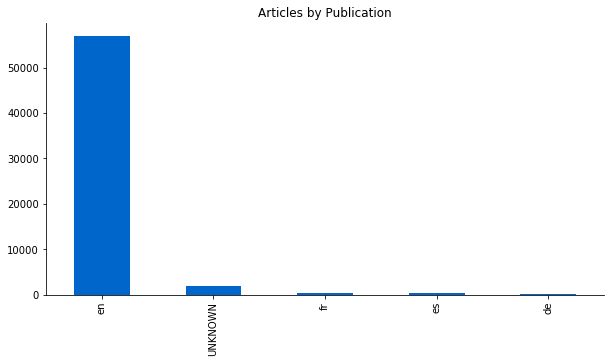

In [13]:
# graph by language
by_lang = df['body_lang'].value_counts().sort_values(ascending=False).head(5)
fig, jd = plt.subplots(figsize=(10, 5))
jd.spines["top"].set_visible(False)
jd.spines["right"].set_visible(False)

by_lang.plot(ax=jd, title="Articles by Publication", kind='bar', color='#0066CC')

In [14]:
df = df[(df.abstract_lang == 'en') & (df.body_lang == 'en')]
df.head()

,paper_id,body_text,cord_uid,source_x,title,doi,pmcid,pubmed_id,license,abstract,...,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,abstract_lang,body_lang
0,bd667dbd5200c9f07fb07cef29435f7ca7c2639b,"Epizootic catarrhal enteritis (EcE), a new ent...",3g75spkc,PMC,Establishment of serological test to detect an...,10.1292/jvms.16-0059,PMC4937135,26935842,cc-by-nc-nd,Since there is no available serological method...,...,"MINAMI, Shohei; TERADA, Yutaka; SHIMODA, Hiros...",J Vet Med Sci,NaN,NaN,True,True,noncomm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,en,en
1,34fca1fbc149711e5617126584d1e26f06e94de9,T he ability to predict and prevent viral epid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The large virus family Paramyxoviridae include...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,en
2,3c3ab717ef79befde82029b1362348708998d17e,IMPORTANCE Most studies examining the host tra...,iftvp09u,PMC,Unique Signatures of Long Noncoding RNA Expres...,10.1128/mbio.00206-10,PMC2962437,20978541,cc-by-nc-sa,Studies of the host response to virus infectio...,...,"Peng, Xinxia; Gralinski, Lisa; Armour, Christo...",mBio,NaN,NaN,True,True,noncomm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,en,en
4,3041dc5ba951755241ae7e75ade271188033d4de,"sequential addition of N-acetylgalactosamine, ...",4pv1zu1g,PMC,O-glycosylation of intact and truncated riboph...,NaN,PMC2289488,1577870,cc-by-nc-sa,Ribophorins I and II are type I transmembrane ...,...,NaN,J Cell Biol,NaN,NaN,True,True,noncomm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,en,en
5,ae1f8642745871a574c0fe8193112b06a8b07212,Human adenovirus 52 (HAdV-52) is one of only t...,pivbr2ke,PMC,Polysialic acid is a cellular receptor for hum...,10.1073/pnas.1716900115,PMC5939068,29674446,cc-by-nc-nd,Human adenovirus 52 (HAdV-52) is one of only t...,...,"Lenman, Annasara; Liaci, A. Manuel; Liu, Yan; ...",Proc Natl Acad Sci U S A,NaN,NaN,True,True,noncomm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,en,en


In [15]:
df['publish_year'] = pd.DatetimeIndex(df['publish_time']).year

In [16]:
# medium model
nlp = en_core_sci_md.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 2000000

customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 
    'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True


def lemmatize_text(text, nlp=nlp):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ if token.lemma_ != "-PRON-" else token.text.lower() for token in doc 
                         if not (token.like_num or token.is_stop or token.is_punct or token.is_space or len(token)==1)]
    return " ".join(lemmatized_tokens)


def normalize_corpus(corpus, nlp=nlp):
    txt = lemmatize_text(corpus, nlp)
    return txt

In [17]:
df['preprocessed_body_text'] = df['body_text'].progress_apply(normalize_corpus)

100%|██████████| 34820/34820 [07:27<00:00, 77.90it/s] 


In [18]:
df.reset_index(inplace = True)

In [19]:
fl = open("../../data/processed/processed_data.pkl", "wb")
pickle.dump(df, fl)
fl.close()

In [20]:
df.to_csv("../../data/processed/processed_data.csv")

# 3) Explore the data

In [21]:
df.head(2)

,index,paper_id,body_text,cord_uid,source_x,title,doi,pmcid,pubmed_id,license,...,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,abstract_lang,body_lang,publish_year,preprocessed_body_text
0,0,bd667dbd5200c9f07fb07cef29435f7ca7c2639b,"Epizootic catarrhal enteritis (EcE), a new ent...",3g75spkc,PMC,Establishment of serological test to detect an...,10.1292/jvms.16-0059,PMC4937135,26935842,cc-by-nc-nd,...,NaN,NaN,True,True,noncomm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,en,en,2016.0,Epizootic catarrhal enteritis EcE new enteric ...
1,1,34fca1fbc149711e5617126584d1e26f06e94de9,T he ability to predict and prevent viral epid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,en,en,NaN,ability predict prevent viral epidemics major ...


# Articles by Source
Graph below shows articles grouped by their source. Most of the articles in our datasets is from PMC and Elsevier. 
PubMed Central(PMC) is a free full-text archive of biomedical and life sciences journal literature at the U.S. National Institutes of Health's National Library of Medicine (NIH/NLM). Elsevier is a global information analytics business specializing in science and health founded in Netherlands.

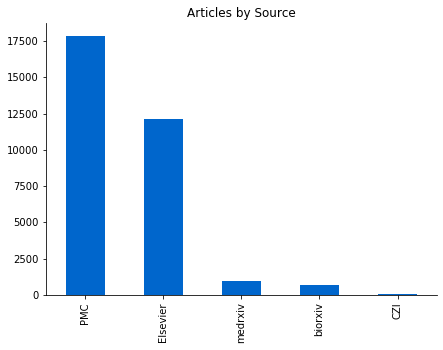

In [22]:
source_data = df['source_x'].value_counts().sort_values(ascending=False)
fig, sd = plt.subplots(figsize=(7, 5))
sd.spines["top"].set_visible(False)
sd.spines["right"].set_visible(False)

source_data.plot(ax=sd, title="Articles by Source", kind='bar', color='#0066CC')

# Articles grouped by Publications
The following graph shows the articles grouped by publication. There are displayed only Top 15 Publications, many articles does not have publication.

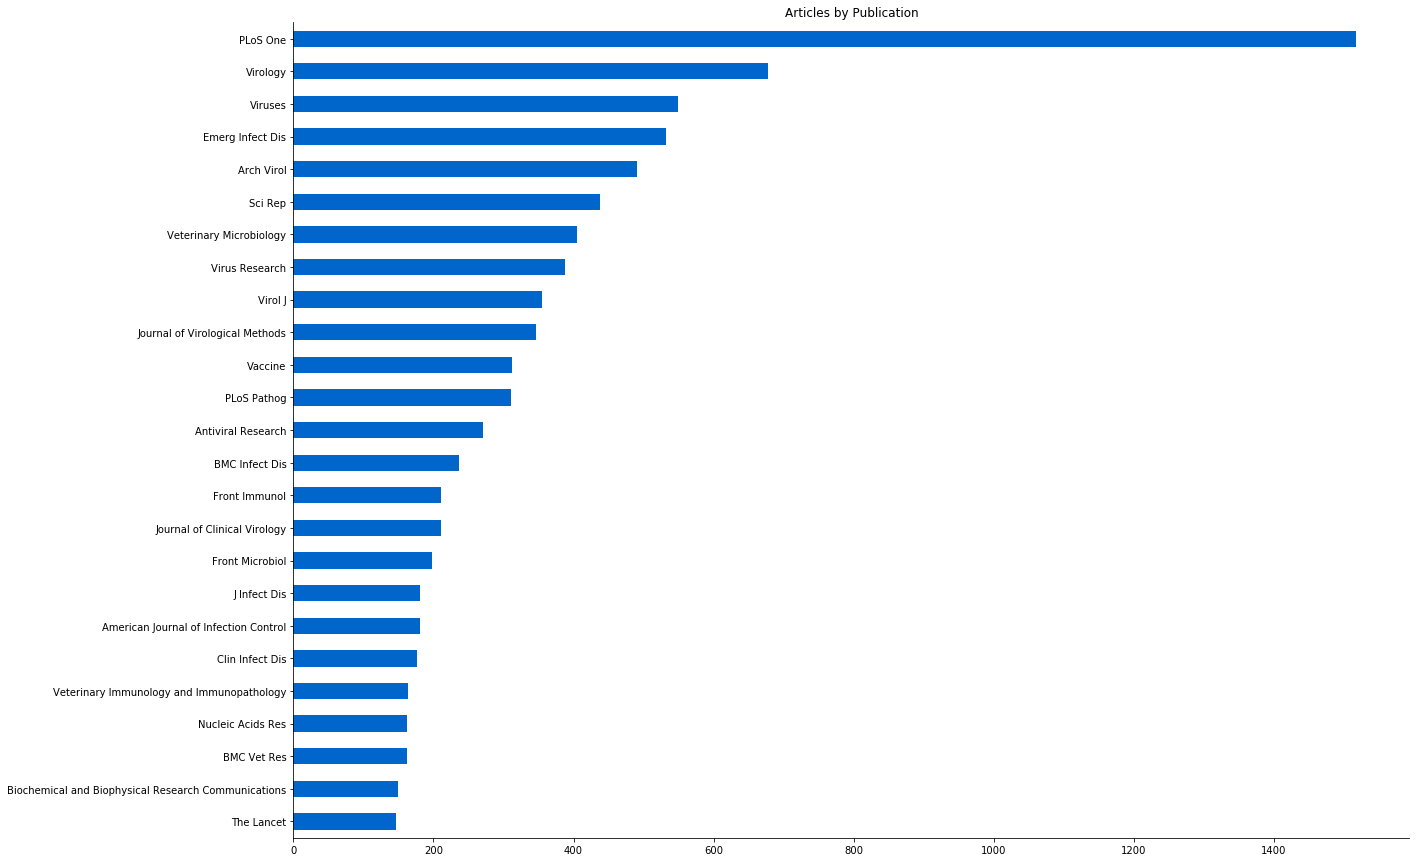

In [23]:
by_journal = df['journal'].value_counts().sort_values(ascending=True).tail(25)
fig, jd = plt.subplots(figsize=(20, 15))
jd.spines["top"].set_visible(False)
jd.spines["right"].set_visible(False)

by_journal.plot(ax=jd, title="Articles by Publication", kind='barh', color='#0066CC')

# Articles by date of published
Graph shows number of articles published every month. Recent months are the most fruitful in coronavirus literature.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


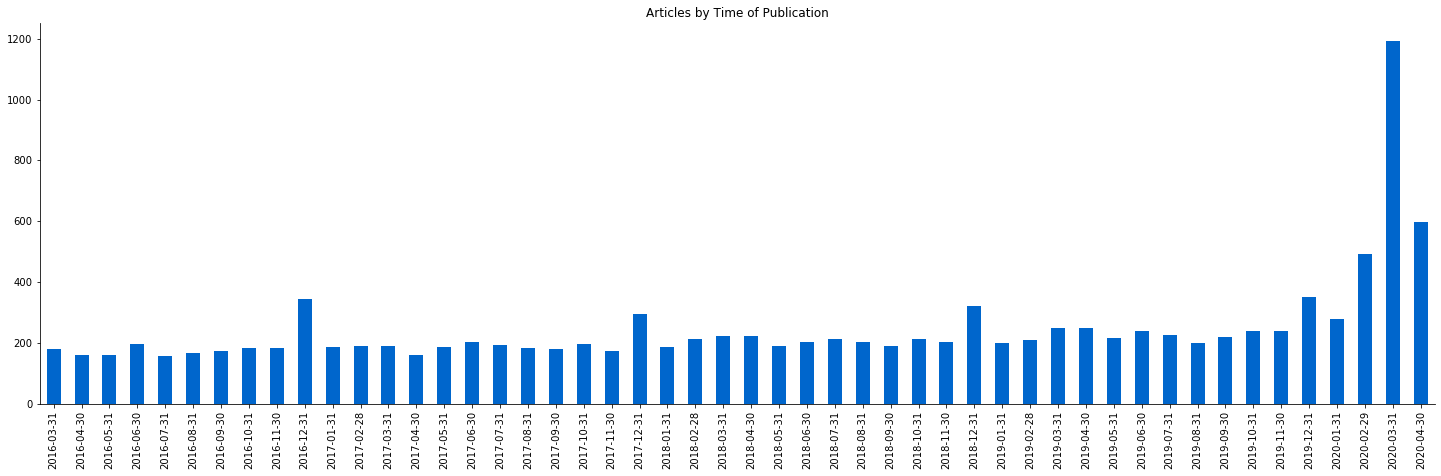

In [27]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df_pb = df[df['publish_time']<=datetime.date(2020,4,30)]
by_pub_time =  df_pb['publish_time'].value_counts().sort_index().groupby(pd.Grouper(freq='M')).sum()[-50:]
by_pub_time.index = by_pub_time.index.date

fig, ax = plt.subplots(figsize=(25, 7))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

by_pub_time.plot(ax=ax, title="Articles by Time of Publication", kind='bar', color='#0066CC')

# Word cloud based on most popular words in Titles

In [28]:
def tokenize_text(text):
    return [token.strip() for token in nltk.word_tokenize(text)]

In [ ]:
nltk.download('punkt')

In [29]:
data_title = df[df['title'].notnull()]
data_title['processed_title'] = data_title['title'].progress_apply(normalize_corpus)
data_title.reset_index(inplace=True)

100%|██████████| 31580/31580 [00:02<00:00, 14615.86it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
words = pd.Series(np.concatenate([tokenize_text(x) for x in data_title['processed_title']])).value_counts()

In [34]:
def wordcloud_plot(df):
    np.random.seed(64)
    
    wc = WordCloud(
    background_color="white",
    max_words=150,
    max_font_size=35,
    scale=5,
    random_state=0).generate_from_frequencies(df)
    
    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    
    plt.imshow(wc)
    plt.show()

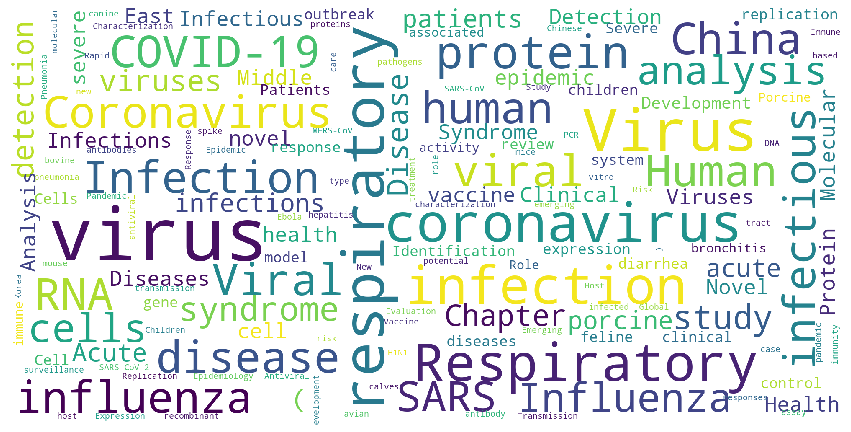

In [35]:
wordcloud_plot(words)

# 4) Clustering

In [ ]:
# loading if needed
fl = open("../../data/processed/processed_data.pkl", "rb")
df = pickle.load(fl)

In [37]:
# compute tf-idf
vectorizer = TfidfVectorizer(max_features=2**12)
X = vectorizer.fit_transform(tqdm(df['preprocessed_body_text']))

100%|██████████| 34820/34820 [00:54<00:00, 637.29it/s]


## Elbow method to choose k parameter

In [ ]:
WCSS = []
for i in tqdm(range(1, 40)):
    km = MiniBatchKMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WCSS.append(km.inertia_)

In [ ]:
plt.plot(range(1, 40), WCSS, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

In [38]:
# run k-means with k = 18
k = 18
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
y_pred = kmeans.fit_predict(X)

## Merge df

In [39]:
# add clusters to data frame
df_cluster = pd.DataFrame(y_pred, columns = ["cluster_k_means"])
df = pd.merge(df, df_cluster, left_index = True, right_index = True)

In [40]:
# save it
fl = open("../../data/processed/df_with_cluster.pkl", "wb")
pickle.dump(df, fl)
fl.close()

In [41]:
df.to_csv("../../data/processed/df_with_cluster.csv")

# 5) Keywords generation

In [11]:
# loading if needed
fl = open("../../data/processed/df_with_cluster.pkl", "rb")
df = pickle.load(fl)

In [10]:
keywords_therapeutic = [
    'clinical trial',
    'therapeutic',
    'therapy',
    'clinical effectiveness',
    'actemra',
    'ADE',
    'inflammatory response',
    'ACE-2',
    'Camostat Mesilate',
    'interferon beta',
    'interferon alpha',
    'tocilizumab']

In [11]:
keywords_vaccine = ['vaccine',
                    'vaccines',
                    'dna',
                    'inactivated',
                    'live attenuated virus',
                    'lav',
                    'non-replicating viral vector',
                    'protein subunit',
                    'replicating viral vector',
                    'rna',
                    'virus-like particle',
                    'vlp',
                    'viral',
                    'anti-viral',
                    'inhibitor',
                    'immune',
                    'antibodies',
                    'adenoviruses',
                    'antigen',
                    'lentiviral',
                    'mrna', 
                    'naproxen', 
                    'clarithromycin',  
                    'minocyclinethat']

In [12]:
keywords_general = ['covid-19', 
                    'coronavirus', 
                    '2019-ncov' , 
                    'covs', 
                    'sars cov2', 
                    'coronae', 
                    'positive-sense rna viruses']

In [13]:
keywords_ade = ['ADE', 
                'Antibody-Dependent Enhancement', 
                'variable S domain', 
                's protein', 
                'p0dtc2', 
                'Spike glycoprotein', 
                'amino acid residue variation analysis', 
                'APC', 
                'Autophagy inhibitors', 
                'HL-CZ human promonocyte cell line', 
                'TNF-α', 
                'IL-4', 
                'IL-6']

In [14]:
keywords_animal = ['animal models', 
                   'mouse', 
                   'guinea pigs', 
                   'golden Syrian hamsters', 
                   'ferrets', 
                   'rabbits', 
                   'rhesus macaques', 
                   'marmosets', 
                   'cats']

In [15]:
keywords_drugs = ['viral inhibitor', 
                  'viral replication', 
                  'clinical trial', 
                  'bench trial', 
                  'clarithromycin', 
                  'minocycline', 
                  'remdesivir',
                  'hydroxychloroquine',
                  'azithromycin', 
                  'lopinavir', 
                  'nsp5', 
                  'C30 Endopeptidase', 
                  'ritonavir', 
                  'actemra', 
                  'naproxen']

In [16]:
keywords = keywords_general + keywords_therapeutic + keywords_vaccine + keywords_ade + keywords_animal + keywords_drugs 

## 6) Tokenize and generate similar keywords

Building vectors for CORD-19 datasets with FastText. Vectors will be use for generating similiar words to keywords.

In [12]:
def split_sentences(text):
    sentences_string = []
    for line in text.split('\n'):
        l = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
        sentences_string.extend(sent for sent in l.groupdict()['postcolon'].split('.') if sent)
    sentences = []
    for sentence in sentences_string:
        token = re.sub(r"[^a-z0-9]+", " ", sentence.lower()).split()
        token = [tok for tok in token if len(tok) > 2]
        token = [x for x in token if not x.isdigit()]
        if len(token) > 2:
            sentences.append(token)
    return sentences

In [13]:
df['sentences'] = df['preprocessed_body_text'].progress_apply(split_sentences) 

100%|██████████| 34820/34820 [01:04<00:00, 543.85it/s]


In [14]:
def flatten(lists):
    results = []
    for row in lists:
        for inside_list in row:
            results.append(inside_list) 
    return results

In [15]:
input_model = flatten(df['sentences'].to_list()) 

In [16]:
model = FastText(size=1000, window=3, min_count=5, workers=4, min_n=2, hs=1)
model.build_vocab(input_model)

In [17]:
model.train(input_model, total_examples=model.corpus_count, epochs=1) 

In [18]:
model.save("../models/fasttext.model") 

In [19]:
model.wv.most_similar("covid-19", topn=5) 

[('covid19', 0.7477694749832153),
 ('covid', 0.7136983871459961),
 ('ncovid', 0.6555148363113403),
 ('covidsim', 0.6544382572174072),
 ('pc4covid19', 0.6083848476409912)]

In [20]:
def generate_keywords(keywords_list):
    model_keys = []
    for key in keywords_list:
        key_generated = model.wv.most_similar(key, topn=5)
        model_keys.append([i[0] for i in key_generated])
    return model_keys

In [21]:
keywords_general_plus = flatten(generate_keywords(keywords_general)) 

In [22]:
keywords_plus = flatten(generate_keywords(keywords)) 

In [23]:
# save it
fl = open("../../data/processed/keywords_general_plus.pkl", "wb")
pickle.dump(keywords_general_plus, fl)
fl.close()

fl = open("../../data/processed/keywords_plus.pkl", "wb")
pickle.dump(keywords_plus, fl)
fl.close()

# 7) Topic modelling

Topic modeling is a type of statistical modeling for discovering the abstract `topics` that occur in a collection of documents. One of the best known techniques to do that is **Latent Dirichlet Allocation (LDA)**. LDA is a machine learning technique that represents documents as mixtures of topics that spit out words with certain probabilities.

In [ ]:
# loading if needed
fl = open("../../data/processed/df_with_cluster.pkl", "rb")
df = pickle.load(fl)

In [22]:
# Count vectorizer works better than tfidf for lda
vectorizer = CountVectorizer(max_features=2**12)
data_vectorized = vectorizer.fit_transform(tqdm(df['preprocessed_body_text']))

100%|██████████| 34820/34820 [00:52<00:00, 662.96it/s]


In [23]:
lda = LatentDirichletAllocation(n_components=20, random_state=0, n_jobs=-1, verbose=True)
lda.fit(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=True)

In [27]:
joblib.dump(lda, '../models/lda.csv')

['../models/lda.csv']

Here we want to see what words are included in different topics

In [28]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [29]:
print_top_words(lda, vectorizer, n_top_words=10)


Topic #0: vaccine vaccines immune vaccination responses delivery immunity response cell antigen

Topic #1: health public disease data risk information countries time control epidemic

Topic #2: pcr samples rna rt positive assay virus detection dna detected

Topic #3: cells protein cell fig expression proteins figure fusion anti binding

Topic #4: patients treatment patient clinical use care risk infection therapy blood

Topic #5: air study lung group patients time temperature rate mean results

Topic #6: cov sars mers ace2 coronavirus human rbd respiratory coronaviruses camels

Topic #7: cells cell expression disease patients immune inflammatory tissue mice levels

Topic #8: infection disease cats calves respiratory clinical study children associated age

Topic #9: protein rna proteins binding sequence structure residues domain site fig

Topic #10: cells mice infection ifn il infected cell virus expression viral

Topic #11: viral protein proteins virus cells expression cell replicatio

And create a dataframe with documents and their topic distribution

In [30]:
doc_topic_dist = pd.DataFrame(lda.transform(data_vectorized))

In [31]:
doc_topic_dist.to_csv('../models/doc_topic_dist.csv', index=False)

In [32]:
# merge to df
doc_topic_dist["cluster_lda"] = doc_topic_dist.apply(lambda x: doc_topic_dist.columns[x.idxmax()], axis = "columns")
df = pd.merge(df, doc_topic_dist[["cluster_lda"]], left_index = True, right_index = True)

In [33]:
# save it
fl = open("../../data/processed/df_with_cluster_both.pkl", "wb")
pickle.dump(df, fl)
fl.close()
df.to_csv("../../data/processed/df_with_cluster_both.csv")

# 8) Filtering

In [4]:
# loading if needed
fl = open("../../data/processed/df_with_cluster_both.pkl", "rb")
df = pickle.load(fl)

In [34]:
# filtering function
def filter_papers_word_list(word_list, data, threshold = 0.3, keywords_general = keywords_general):
    papers_id_list = []
    for idx, paper in tqdm(data.iterrows(), total=df.shape[0]):
        keys_in_text = [x in paper.body_text for x in word_list]
        keys_general_in_text = [x in paper.body_text for x in keywords_general]
        if (sum(keys_in_text) / len(word_list) > threshold) & any(keys_general_in_text):
            papers_id_list.append(paper.paper_id)
    return papers_id_list

### Summary of filtering analysis (code below)
threshold = 0.5 -> 0 rows in filtered data frame

threshold = 0.38 -> 7 rows
  * top k_means clusters: 1, 14, 11
  * top lda clusters: 7, 8, 4, 6

threshold = 0.3 -> ??
  * top k_means clusters: ?
  * top lda clusters: ?

threshold = 0.25 -> ??
  * top k_means clusters: ?
  * top lda clusters: ?

threshold = 0.2 -> ??
  * top k_means clusters: ?
  * top lda clusters: ?

### Filtering analysis - code

In [35]:
df.shape

(34820, 27)

In [36]:
# get cluster proportions
def cluster_prop(data, var_name):
    prop = data[var_name].value_counts().sort_values(ascending = False).to_frame().rename(columns = {var_name: "count"})
    prop["prop_count"] = prop["count"] / prop["count"].sum()
    return prop

In [47]:
# iteratively change threshold -> rerun
filtered_general = filter_papers_word_list(keywords, df, threshold = 0.375)
df_keywords = df[df['paper_id'].isin(filtered_general)]
df_keywords.shape

100%|██████████| 34820/34820 [01:23<00:00, 418.03it/s]


(7, 27)

In [48]:
cluster_prop(df, "cluster_lda").head(6)

,count,prop_count
1,4133,0.118696
16,3647,0.104739
12,2245,0.064474
2,2045,0.058731
9,2016,0.057898
3,1903,0.054652


In [49]:
cluster_prop(df_keywords, "cluster_lda").head(6)

,count,prop_count
7,4,0.571429
8,1,0.142857
4,1,0.142857
6,1,0.142857


In [50]:
cluster_prop(df, "cluster_k_means").head(6)

,count,prop_count
2,7608,0.218495
12,4826,0.138599
5,4145,0.119041
1,3104,0.089144
14,2606,0.074842
17,2159,0.062005


In [51]:
cluster_prop(df_keywords, "cluster_k_means").head(6)

,count,prop_count
1,4,0.571429
14,2,0.285714
11,1,0.142857


Similar analysis for keywords_plus

In [ ]:
# iteratively change threshold -> rerun
filtered_general = filter_papers_word_list(keywords_plus, df, threshold = 0.15)
df_keywords = df[df['paper_id'].isin(filtered_general)]

In [ ]:
df_keywords.shape 

In [ ]:
cluster_prop(df_keywords, "cluster_lda").head(6) 

In [ ]:
cluster_prop(df_keywords, "cluster_k_means").head(6) 

# 8.1) 

### Proceed with articles specified by keywords and by both clustering methods

In [52]:
papers_8_1 = filter_papers_word_list(keywords, df, threshold = 0.38)
df_keywords_th_04 = df[df['paper_id'].isin(papers_8_1)]
df_keywords_th_04.shape

100%|██████████| 34820/34820 [01:23<00:00, 418.09it/s]


(7, 27)

In [53]:
fl = open("../../data/processed/df_filtered_threshold-04_keywords-all.pkl", "wb")
pickle.dump(df_keywords_th_04, fl)
fl.close()

# 8.2) 

### Proceed with articles specified by keywords with threshold 0.3 and by both clustering methods

In [54]:
# need to be re-run

# papers_8_2 = filter_papers_word_list(keywords, df, threshold = 0.3)
# df_keywords_th_03_clust = df[df['paper_id'].isin(papers_8_2) & 
#                              df["cluster_lda"].isin([15, 7, 12, 6]) & 
#                              df["cluster_k_means"].isin([16, 9, 12, 6])]
# df_keywords_th_03_clust.shape 

In [55]:
# fl = open("../../data/processed/df_filtered_threshold-03_both-clusters_keywords-all.pkl", "wb")
# pickle.dump(df_keywords_th_03_clust, fl)
# fl.close()

# 8.3) 

### Proceed with articles specified by keywords_plus only

In [56]:
# need to be re-run

# papers_8_3 = filter_papers_word_list(keywords_plus, df, threshold = 0.15)
# df_keywords_plus_th_015 = df[df['paper_id'].isin(papers_8_3)]
# df_keywords_plus_th_015.shape

In [57]:
# fl = open("../../data/processed/df_filtered_threshold-015_keywords-all-plus.pkl", "wb")
# pickle.dump(df_keywords_plus_th_015, fl)
# fl.close()

# 9) Get similar documents for LDA

In [5]:
doc_topic_dist = pd.read_csv('../models/doc_topic_dist.csv')

In [6]:
def get_k_nearest_docs(doc_dist, k=5, lower=1950, upper=2020, only_covid19=False, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
    
    relevant_time = df.publish_year.between(lower, upper)
    
    if only_covid19:
        temp = doc_topic_dist[relevant_time & is_covid19_article]
        
    else:
        temp = doc_topic_dist[relevant_time]
         
    distances = temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest

In [7]:
def recommendation(paper_id, k=5, lower=1950, upper=2020, only_covid19=False, plot_dna=False):
    '''
    Returns the title of the k papers that are closest (topic-wise) to the paper given by paper_id.
    '''

    recommended, dist = get_k_nearest_docs(doc_topic_dist[df.paper_id == paper_id].loc[0], k, lower, upper, only_covid19, get_dist=True)
    recommended = df.iloc[recommended].copy()
    recommended['similarity'] = 1 - dist 
    
    h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' +' (Similarity: ' + "{:.2f}".format(s) + ')' for l, n, s in recommended[['url','title', 'similarity']].values])
    display(HTML(h))

In [8]:
#example
recommendation('bd667dbd5200c9f07fb07cef29435f7ca7c2639b', k=5)

Get documents similar to the question in the task

In [17]:
task = ["Effectiveness of drugs being developed and tried to treat COVID-19 patients.",
"Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.",
      ' '.join(keywords)]

tasks={'What do we know about vaccines and therapeutics?': task}

In [20]:
def relevant_articles(tasks, k=3, lower=1950, upper=2020, only_covid19=False):
    relevant_articles_dict = {}
    tasks = [tasks] if type(tasks) is str else tasks 
    
    tasks_vectorized = vectorizer.transform(tasks)
    tasks_topic_dist = pd.DataFrame(lda.transform(tasks_vectorized))

    for index, bullet in enumerate(tasks):
        print(bullet)
        recommended = get_k_nearest_docs(tasks_topic_dist.iloc[index], k, lower, upper, only_covid19)
        recommended = df.iloc[recommended]
        relevant_articles_dict.update({bullet: recommended})
    
    return relevant_articles_dict

In [24]:
relevant_dict = relevant_articles(task, 5, only_covid19=False)

Effectiveness of drugs being developed and tried to treat COVID-19 patients.
Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.
covid-19 coronavirus 2019-ncov covs sars cov2 coronae positive-sense rna viruses clinical trial therapeutic therapy clinical effectiveness actemra ADE inflammatory response ACE-2 Camostat Mesilate interferon beta interferon alpha tocilizumab vaccine vaccines dna inactivated live attenuated virus lav non-replicating viral vector protein subunit replicating viral vector rna virus-like particle vlp viral anti-viral inhibitor immune antibodies adenoviruses antigen lentiviral mrna naproxen clarithromycin minocyclinethat ADE Antibody-Dependent Enhancement variable S domain s protein p0dtc2 Spike glycoprotein amino acid residue variation analysis APC Autophagy inhibitors HL-CZ human promonocyte cell line TNF-α IL-4 IL-6 animal models 

Add summary to this documents

In [33]:
def add_summary(simmilar_dict):

    model = Summarizer()
    for (key, df) in tqdm(simmilar_dict.items()):
        df['summary'] = df['body_text'].progress_apply(lambda x: model(x, min_length=10, max_length = 200))
        simmilar_dict.update({key: df})
    return simmilar_dict

Display results in HTML format

In [35]:
def display_results(relevant_dict):
    for key, df in relevant_dict.items():
        print(key)
        h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' + '<p>' + s + '</p>' for l, n, s in df[['url','title', 'abstract']].values])
        display(HTML(h))

In [36]:
display_results(relevant_dict)

Effectiveness of drugs being developed and tried to treat COVID-19 patients.


Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.


covid-19 coronavirus 2019-ncov covs sars cov2 coronae positive-sense rna viruses clinical trial therapeutic therapy clinical effectiveness actemra ADE inflammatory response ACE-2 Camostat Mesilate interferon beta interferon alpha tocilizumab vaccine vaccines dna inactivated live attenuated virus lav non-replicating viral vector protein subunit replicating viral vector rna virus-like particle vlp viral anti-viral inhibitor immune antibodies adenoviruses antigen lentiviral mrna naproxen clarithromycin minocyclinethat ADE Antibody-Dependent Enhancement variable S domain s protein p0dtc2 Spike glycoprotein amino acid residue variation analysis APC Autophagy inhibitors HL-CZ human promonocyte cell line TNF-α IL-4 IL-6 animal models mouse guinea pigs golden Syrian hamsters ferrets rabbits rhesus macaques marmosets cats viral inhibitor viral replication clinical trial bench trial clarithromycin minocycline remdesivir hydroxychloroquine azithromycin lopinavir nsp5 C30 Endopeptidase ritonavir a

# 10) General summary of filtered dataset

In [3]:
# loading if needed
fl = open("../../data/processed/df_filtered_threshold-04_keywords-all.pkl", "rb")
df_keywords_th_04 = pickle.load(fl)
df_keywords_th_04.shape

(7, 27)

In [4]:
from gensim.summarization.summarizer import summarize 
from gensim.summarization import keywords
def all_summary(df):
    all_txt = ' '.join(df["body_text"])
    summary = summarize(all_txt, word_count = 1000)
    return summary

In [ ]:
all_summary(df_keywords_th_04)